In [1]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using LaTeXStrings

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007f608dfd35eb, Ptr{Nothing} @0x00007f608dfa4204, P

# Simulation of sliding box

In [ ]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
# open(mvis)

In [ ]:
N = 10
Δt = 0.1
q0 = [0., 0.2, 0.]
v0 = [8., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt,relax_comp=true)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
# Direct (both normal and friction)

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

In [ ]:
j = 1
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [ ]:
sim_indirect[1][end]

# Trajectory optimization of sliding box

In [56]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [57]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
# open(mvis)

MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,Fixed{Float64}},1},Array{Joint{Float64,Planar{Float64}},1}},2}},Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat, 2)

In [76]:
# qN = [3.0, 0., 0.]
# N = 10

# qN = [3.0, 0., 0.]
# N = 15

# qN = [3.0, 0., 0.]
# N = 20

# qN = [3.0, 0., 0.]
# N = 25

# qN = [5.0, 0., 0.]
# N = 30

qN = [10.0, 0., 0.]
N = 35

# qN = [15.0, 0., 0.]
# N = 40

q1 = [0., 0.2, 0.]
Δt = 0.1

q_min = [-10., -10., -10.]
q_max = [10., 10., 10.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - qN[1:2])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

get_prob_init (generic function with 1 method)

In [77]:
# Semidirect
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 5000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
 38.311243 seconds (156.91 M allocations: 25.160 GiB, 22.76% gc time)


(Array{Float64,1}[[0.0, 0.2, 0.0], [1.40151, 0.102317, 0.0574336], [2.71221, -1.97883e-15, 0.114867], [3.83686, -6.98185e-18, 0.172301], [4.86694, 0.0, 0.229734], [5.80261, 0.0, 0.287168], [6.64402, 0.0, 0.344602], [7.39133, 0.0, 0.402035], [8.04467, 2.58494e-26, 0.459469], [8.60421, 0.0, 0.516902]  …  [10.0, 0.0, 1.43584], [10.0, -3.10193e-25, 1.49327], [10.0, 0.0, 1.55071], [10.0, 0.0, 1.60814], [10.0, 5.16988e-26, 1.66557], [10.0, 0.0, 1.72301], [10.0, 0.0, 1.78044], [10.0, 4.3074e-21, 1.83788], [10.0, 2.66151e-17, 1.89531], [10.0, 0.0, 1.95274]], Array{Float64,1}[[14.0954, 0.0, 0.574336], [13.9359, -1.77972, 0.574336], [12.9034, -2.51869, 0.574336], [11.0799, -1.92819, 0.574336], [10.0302, -2.34569, 0.574336], [8.97356, -2.65017, 0.574336], [7.91947, -2.84248, 0.574336], [6.87719, -2.92414, 0.574336], [5.85586, -2.8974, 0.574336], [4.86435, -2.76517, 0.574336]  …  [-8.53507e-12, 6.28587e-11, 0.574336], [-3.90879e-12, 5.03201e-11, 0.574336], [-2.80788e-13, 2.81868e-11, 0.574336], [-

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [66]:
Bilevel.solve_rosenbrock(); # clearing SNOPT

In [78]:
# Indirect
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 5000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)

@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

Finished successfully: optimality conditions satisfied
 22.861190 seconds (150.17 M allocations: 19.188 GiB, 28.41% gc time)


(Array{Float64,1}[[0.0, 0.2, 0.0], [1.44919, 0.101922, -0.0155368], [2.80253, 2.0754e-7, -0.0310736], [3.95093, 0.0, -0.0466104], [4.99954, -1.3489e-13, -0.0621471], [5.94838, 7.14919e-15, -0.0776839], [6.79745, 4.9131e-15, -0.0932207], [7.54678, -1.03398e-25, -0.108758], [8.19636, 0.0, -0.124294], [8.74621, 7.08986e-14, -0.139831]  …  [10.0, 6.40878e-19, -0.38842], [10.0, 4.12626e-14, -0.403956], [10.0, 3.14795e-14, -0.419493], [10.0, -6.79304e-14, -0.43503], [10.0, 1.45937e-13, -0.450567], [10.0, -1.8791e-13, -0.466104], [10.0, 0.0, -0.48164], [10.0, 0.0, -0.497177], [10.0, 0.0, -0.512714], [10.0, 0.0, -0.528251]], Array{Float64,1}[[14.4784, 0.0, -0.155368], [14.5054, -0.755515, -0.155368], [13.5585, -0.598261, -0.155368], [11.4715, 0.535078, -0.155368], [10.4659, 0.651264, -0.155368], [9.45976, 0.736353, -0.155368], [8.45387, 0.790366, -0.155368], [7.44894, 0.813338, -0.155368], [6.44571, 0.805316, -0.155368], [5.44488, 0.766364, -0.155368]  …  [-7.0912e-8, 3.63551e-8, -0.155368], [

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

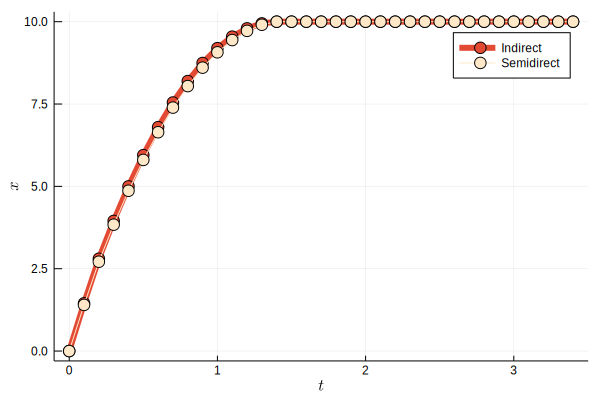

In [79]:
j = 1
xlabel=latexstring("t")
ylabel=latexstring("x")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [74]:
savefig(string("slidingbox_x_4.svg")) 

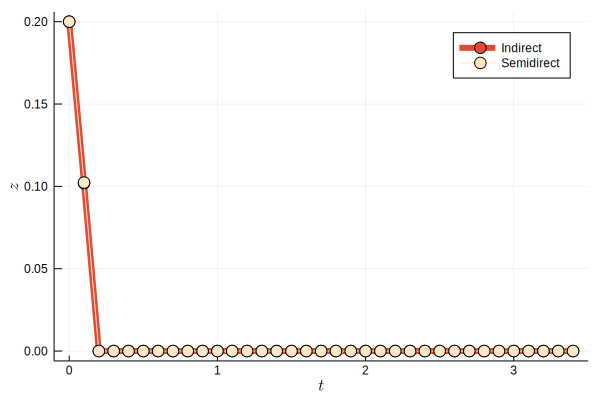

In [80]:
j = 2
xlabel=latexstring("t")
ylabel=latexstring("z")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [75]:
savefig(string("slidingbox_z_4.svg")) 

In [7]:
display(traj_indirect[2][end])
display(traj_semidirect[2][end])

3-element Array{Float64,1}:
 0.0                   
 4.1359030627651384e-24
 0.9002303388292213    

3-element Array{Float64,1}:
 0.0                 
 0.019438219345822134
 1.7453292392539714  

In [28]:
display(length(traj_indirect[9]))
display(length(traj_semidirect[9]))

652

380

# Trajectory optimization of jumper robot

In [ ]:
urdf = joinpath("..", "..", "urdf", "jumper", "jumper.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 100.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

In [ ]:
set_configuration!(mvis, [0., -2, .6, -1.2])

In [ ]:
N = 10
Δt = 0.05
q0 = [0., -2, .6, -1.2]
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [ ]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-20., -10., -pi, -pi])
q_max = max.(q_nom, [20., -0.25, pi, pi])

N = 20
Δt = 0.025

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1x, 4, x -> vs(x, :q1)[1:4] - q_nom[1:4])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    
    add_eq!(sim_data, :cqNy, 1, x -> -1.25 - vs(x, Symbol("q", N))[2])
end

function add_prob_obj!(sim_data)
    vs = sim_data.vs    

end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_limit = [0.,0.,0.,100.]
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit .* ones(num_velocities(mechanism)), u_limit .* ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

In [ ]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-4
obj_tol = 1e-4
max_iter = 5000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [ ]:
qi = 1

In [ ]:
q = traj_semidirect[1][qi]
set_configuration!(mvis, q) 
qi += 1

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-4
obj_tol = 1e-4
max_iter = 5000

display(@time traj_inidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_inidirect[9]

setanimation!(mvis, traj_inidirect[7], traj_inidirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

# Trajectory optimization of little dog

In [29]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [35]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
# open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8700
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

Invalid MIT-MAGIC-COOKIE-1 key[9367:9367:0830/134317.187477:ERROR:browser_main_loop.cc(279)] Gtk: cannot open display: :0
Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(We

In [31]:
N = 8
Δt = 0.025
q0 = [0., -.25, 0., 0.25, -0.25, 0.25, -0.25, pi/4, pi/4, pi/4, pi/4, -pi/2, -pi/2, -pi/2, -pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [ ]:
set_configuration!(mvis, [0,-.2,0,0,0,0,0,0,0,0,0,-1.5,-1.5,0,0])

In [32]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -0.1*pi, 0.25, -0.25, 0.25, -0.25, -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
# q_min = min.(q_nom, [-5., -.5, -0.1*pi, 0.25, -0.25, 0.25, -0.25, -3.5, -3.5, -3.5, -3.5, -1.5, -1.5, -3.1, -3.1])
# q_min = min.(q_nom, [-5., -.5, -0.05*pi, 0.25, -0.25, 0.25, -0.25, -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.07, 0.05*pi, 0.25, -0.25, 0.25, -0.25, 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

# x_goal = 0.25
x_goal = .2
N = 12
Δt = 0.05

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1x, 1, x -> vs(x, :q1)[1])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))

    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
    
    add_eq!(sim_data, :cqN, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))
    
    # symmetry
    for n = 1:N
        add_eq!(sim_data, Symbol("cqSym1_", n), 1, x -> vs(x, Symbol("q", n))[8] - vs(x, Symbol("q", n))[9])
        add_eq!(sim_data, Symbol("cqSym2_", n), 1, x -> vs(x, Symbol("q", n))[10] - vs(x, Symbol("q", n))[11])
        add_eq!(sim_data, Symbol("cqSym3_", n), 1, x -> vs(x, Symbol("q", n))[12] - vs(x, Symbol("q", n))[13]) 
        add_eq!(sim_data, Symbol("cqSym4_", n), 1, x -> vs(x, Symbol("q", n))[14] - vs(x, Symbol("q", n))[15]) 
    end
    
#     # start at stance (optional for gait)
#     cn0 = .5
#     add_ineq!(sim_data, Symbol("cn1_", 1), 1, x -> cn0 .- vs(x, Symbol("c_n1_", 1)))
#     add_ineq!(sim_data, Symbol("cn2_", 1), 1, x -> cn0 .- vs(x, Symbol("c_n2_", 1)))
#     add_ineq!(sim_data, Symbol("cn3_", 1), 1, x -> cn0 .- vs(x, Symbol("c_n3_", 1)))
#     add_ineq!(sim_data, Symbol("cn4_", 1), 1, x -> cn0 .- vs(x, Symbol("c_n4_", 1)))
    
    # middle should be contact free
    flight_start = 6
    flight_end = 6
    for n = flight_start:flight_end
        add_eq!(sim_data, Symbol("cn1f_", n), 1, x -> vs(x, Symbol("c_n1_", n)))
        add_eq!(sim_data, Symbol("cn2f_", n), 1, x -> vs(x, Symbol("c_n2_", n)))
        add_eq!(sim_data, Symbol("cn3f_", n), 1, x -> vs(x, Symbol("c_n3_", n)))
        add_eq!(sim_data, Symbol("cn4f_", n), 1, x -> vs(x, Symbol("c_n4_", n)))
    end
end

function add_prob_obj!(sim_data)
    vs = sim_data.vs    
#     for n = 1:N
#         add_obj!(sim_data, Symbol("v", n), x -> sim_data.vs(x, Symbol("v", n))' * sim_data.vs(x, Symbol("v", n)))
#     end
end

function get_prob_limits(sim_data)
    x_min = -1e12*ones(sim_data.vs.num_vars)
    x_max = 1e12*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_mag_max = 5.
    u_min = vcat(zeros(3), -u_mag_max * ones(12))
    u_max = vcat(zeros(3), u_mag_max * ones(12))
    add_box_con_snopt!(x_min, x_max, sim_data, :u, u_min, u_max, 1:N-1)
    
    # joint velocity limits
    v_mag_max = 20.
    v_min = vcat(-1e12*ones(3), -v_mag_max * ones(12))
    v_max = vcat(1e12*ones(3), v_mag_max * ones(12))
    add_box_con_snopt!(x_min, x_max, sim_data, :v, v_min, v_max, 1:N)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - 0.) + 0.
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [37]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [38]:
con_tol = 1e-5
obj_tol = 1e-5
# max_iter = 5000
max_iter = 15000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

(Array{Float64,1}[[0.0, -0.0986209, 0.149383, 0.215236, -0.215236, 0.25, -0.237887, -1.32413, -1.32413, 0.431249, 0.431249, -0.0163267, -0.0163267, -1.27352, -1.27352], [0.00104027, -0.0764609, 0.154119, 0.25, -0.25, 0.242352, -0.249964, -0.876549, -0.876549, 0.352359, 0.352359, -1.01633, -1.01633, -1.47358, -1.47358], [0.00752399, -0.0744775, -0.0674477, 0.218026, -0.218026, 0.249997, -0.249997, -0.373973, -0.373973, 1.31357, 1.31357, -1.18707, -1.18707, -2.02845, -2.02845], [0.0139137, -0.07, 0.156944, 0.25, -0.25, 0.243148, -0.249824, -0.102789, -0.102789, 0.902361, 0.902361, -2.13083, -2.13083, -1.77642, -1.77642], [0.0434451, -0.114973, -0.314021, 0.21524, -0.21524, 0.25, -0.246224, 0.531467, 0.531467, 1.87948, 1.87948, -1.13083, -1.13083, -1.98682, -1.98682], [0.0680427, -0.157732, -0.221031, 0.216863, -0.222821, 0.250001, -0.237905, -0.454225, -0.454225, 0.897918, 0.897918, -0.939925, -0.939925, -0.98682, -0.98682], [0.0994766, -0.174752, -0.13556, 0.2424, -0.232748, 0.242352, -

Finished successfully: optimality conditions satisfied
 41.065514 seconds (156.47 M allocations: 34.052 GiB, 23.84% gc time)


In [39]:
x0 = get_prob_init(sim_data);
display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

Finished successfully: optimality conditions satisfied


(Array{Float64,1}[[0.0, -0.0986209, 0.149383, 0.215236, -0.215236, 0.25, -0.237887, -1.32413, -1.32413, 0.431249, 0.431249, -0.0163267, -0.0163267, -1.27352, -1.27352], [0.00104027, -0.0764609, 0.154119, 0.25, -0.25, 0.242352, -0.249964, -0.876549, -0.876549, 0.352359, 0.352359, -1.01633, -1.01633, -1.47358, -1.47358], [0.00752399, -0.0744775, -0.0674477, 0.218026, -0.218026, 0.249997, -0.249997, -0.373973, -0.373973, 1.31357, 1.31357, -1.18707, -1.18707, -2.02845, -2.02845], [0.0139137, -0.07, 0.156944, 0.25, -0.25, 0.243148, -0.249824, -0.102789, -0.102789, 0.902361, 0.902361, -2.13083, -2.13083, -1.77642, -1.77642], [0.0434451, -0.114973, -0.314021, 0.21524, -0.21524, 0.25, -0.246224, 0.531467, 0.531467, 1.87948, 1.87948, -1.13083, -1.13083, -1.98682, -1.98682], [0.0680427, -0.157732, -0.221031, 0.216863, -0.222821, 0.250001, -0.237905, -0.454225, -0.454225, 0.897918, 0.897918, -0.939925, -0.939925, -0.98682, -0.98682], [0.0994766, -0.174752, -0.13556, 0.2424, -0.232748, 0.242352, -

 41.013594 seconds (156.45 M allocations: 34.050 GiB, 23.83% gc time)


┌ Error: error handling request
│   exception = (Base.IOError("stream is closed or unusable", 0), Base.StackTraces.StackFrame[check_open at stream.jl:323 [inlined], uv_write_async(::TCPSocket, ::Ptr{UInt8}, ::UInt64) at stream.jl:871, uv_write(::TCPSocket, ::Ptr{UInt8}, ::UInt64) at stream.jl:845, unsafe_write(::TCPSocket, ::Ptr{UInt8}, ::UInt64) at stream.jl:901, unsafe_write at ConnectionPool.jl:134 [inlined], macro expansion at gcutils.jl:87 [inlined], write at io.jl:165 [inlined], closebody at Streams.jl:111 [inlined], closewrite(::Stream{Request,Transaction{TCPSocket}}) at Streams.jl:126, (::##13#14{#_servercoroutine#11{ServerWS},Transaction{TCPSocket},Stream{Request,Transaction{TCPSocket}}})() at task.jl:259])
└ @ HTTP.Servers /home/blandry/.julia/packages/HTTP/wY7Vc/src/Servers.jl:364


In [40]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [41]:
qi = 1

1

In [53]:
q = traj_semidirect[1][qi]
set_configuration!(mvis, q) 
qi += 1

13

Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
maximum(abs.(vcat(traj_semidirect[2]...)))

In [ ]:
cntraj = hcat(traj_semidirect[5]...)
front_traj = cntraj[1,:] .+ cntraj[2,:]
back_traj = cntraj[3,:] .+ cntraj[4,:];

In [ ]:
xlabel=latexstring("t")
ylabel=latexstring("c_n")
plot(traj_semidirect[7][1:end-1],front_traj,label="Front legs",seriescolor=RGB(((227,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7][1:end-1],back_traj,label="Back legs",seriescolor=RGB(((154,132,200) ./ 255.)...),linewidth=6,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("littledog_3.svg")) 

In [ ]:
xlabel=latexstring("x")
ylabel=latexstring("z")
plot(traj_semidirect[8][1,:],-traj_semidirect[8][2,:],front_traj,label="Torso center of mass position",seriescolor=RGB(((127,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel,ylabel=ylabel)

In [ ]:
savefig(string("littledogcom_3.svg")) 

In [ ]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [ ]:
# Multi-steps

reps = 3

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 1000

display(@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];